In [1]:
# Load DataFrame and Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

In [2]:
# Full 6D r,v elements

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [3]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, predicted_feature]) # 2 stands for prediction of Z!!! (3rd col)
    return np.array(dataX), np.array(dataY)

In [4]:
# Function

def train_vector(df, predicted_feature):
    
    # load the dataset
    dataset = df.values
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.8) 
    test_size = len(dataset) - train_size
    train=dataset[0 : train_size]
    test=dataset[train_size - 60 : ]
    
    #Scale the data
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    # reshape into X=t and Y=t+1
    look_back = 60 # this is the window
    trainX, trainY = create_dataset(train, look_back)  
    testX, testY = create_dataset(test, look_back)
    # reshape input to be  [length of train/test data, window size (def=60), features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 6))
    testX = np.reshape(testX, (testX.shape[0],look_back, 6))
    
    # Build the LSTM model
    # Note: replace LSTM with GRU or RNN if you want to try those
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (look_back, 6)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    history=model.fit(trainX, trainY, batch_size=256, epochs=100)

    predictions = model.predict(testX)
    predict_ext = np.zeros((len(predictions), 6))
    predict_ext[:,predicted_feature] = predictions[:,0]
    predictions = scaler.inverse_transform(predict_ext)[:,predicted_feature]
    
    testY_extended = np.zeros((len(testY),6))
    testY_extended[:,predicted_feature]=testY
    testY=scaler.inverse_transform(testY_extended)[:,predicted_feature]
    
    rmse = np.sqrt(np.mean(((predictions - testY) ** 2)))
    print(f'RMSE for feature {predicted_feature} is: ' + str(rmse))
    
    pred=np.reshape(predictions, (predictions.shape[0]))
    pred_s=pd.Series(pred)
    df_pred[str(predicted_feature)]=pred_s
    
    #Output dataframe of predictions in 6 dimensions r,v
    return df_pred

In [6]:
# Call for full 6D training

# Init empty predictions DF
df_pred= pd.DataFrame(columns=['0', '1', '2', '3', '4', '5'])

for predicted_feature in range(0,6):
    train_vector(df, predicted_feature)

#Rename predictions df columns from numerals
df_pred.columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv']
df_pred

Epoch 1/100
3/3 [==============================] - 0s 145ms/step - loss: 0.1969
Epoch 2/100
3/3 [==============================] - 0s 143ms/step - loss: 0.1202
Epoch 3/100
3/3 [==============================] - 0s 144ms/step - loss: 0.0920
Epoch 4/100
3/3 [==============================] - 0s 126ms/step - loss: 0.0666
Epoch 5/100
3/3 [==============================] - 0s 124ms/step - loss: 0.0400
Epoch 6/100
3/3 [==============================] - 0s 131ms/step - loss: 0.0250
Epoch 7/100
3/3 [==============================] - 0s 131ms/step - loss: 0.0059
Epoch 8/100
3/3 [==============================] - 0s 141ms/step - loss: 0.0070
Epoch 9/100
3/3 [==============================] - 0s 133ms/step - loss: 0.0082
Epoch 10/100
3/3 [==============================] - 0s 136ms/step - loss: 0.0081
Epoch 11/100
3/3 [==============================] - 0s 124ms/step - loss: 0.0030
Epoch 12/100
3/3 [==============================] - 0s 133ms/step - loss: 0.0026
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 141ms/step - loss: 7.6685e-05
Epoch 98/100
3/3 [==============================] - 0s 162ms/step - loss: 7.8823e-05
Epoch 99/100
3/3 [==============================] - 1s 196ms/step - loss: 7.5896e-05
Epoch 100/100
3/3 [==============================] - 1s 192ms/step - loss: 7.1385e-05
RMSE for feature 0 is: 885.8479111884631
Epoch 1/100
3/3 [==============================] - 0s 139ms/step - loss: 0.1447
Epoch 2/100
3/3 [==============================] - 1s 176ms/step - loss: 0.0713
Epoch 3/100
3/3 [==============================] - 1s 185ms/step - loss: 0.0455
Epoch 4/100
3/3 [==============================] - 1s 170ms/step - loss: 0.0158
Epoch 5/100
3/3 [==============================] - 1s 189ms/step - loss: 0.0121
Epoch 6/100
3/3 [==============================] - 1s 184ms/step - loss: 0.0039
Epoch 7/100
3/3 [==============================] - 1s 181ms/step - loss: 0.0102
Epoch 8/100
3/3 [==============================] - 1s 177ms/step - loss

3/3 [==============================] - 0s 119ms/step - loss: 5.4367e-05
Epoch 94/100
3/3 [==============================] - 0s 129ms/step - loss: 5.2311e-05
Epoch 95/100
3/3 [==============================] - 0s 120ms/step - loss: 5.2917e-05
Epoch 96/100
3/3 [==============================] - 0s 132ms/step - loss: 5.0568e-05
Epoch 97/100
3/3 [==============================] - 0s 138ms/step - loss: 5.2436e-05
Epoch 98/100
3/3 [==============================] - 0s 126ms/step - loss: 5.1158e-05
Epoch 99/100
3/3 [==============================] - 0s 134ms/step - loss: 5.1917e-05
Epoch 100/100
3/3 [==============================] - 0s 124ms/step - loss: 4.9997e-05
RMSE for feature 1 is: 852.1000782715399
Epoch 1/100
3/3 [==============================] - 1s 240ms/step - loss: 0.0965
Epoch 2/100
3/3 [==============================] - 1s 213ms/step - loss: 0.0436
Epoch 3/100
3/3 [==============================] - 1s 215ms/step - loss: 0.0419
Epoch 4/100
3/3 [==============================] - 

3/3 [==============================] - 1s 168ms/step - loss: 4.5163e-05
Epoch 91/100
3/3 [==============================] - 0s 162ms/step - loss: 4.0016e-05
Epoch 92/100
3/3 [==============================] - 0s 156ms/step - loss: 3.7769e-05
Epoch 93/100
3/3 [==============================] - 0s 152ms/step - loss: 3.8902e-05
Epoch 94/100
3/3 [==============================] - 0s 143ms/step - loss: 3.9161e-05
Epoch 95/100
3/3 [==============================] - 0s 150ms/step - loss: 4.4737e-05
Epoch 96/100
3/3 [==============================] - 0s 151ms/step - loss: 3.9727e-05
Epoch 97/100
3/3 [==============================] - 0s 148ms/step - loss: 3.9063e-05
Epoch 98/100
3/3 [==============================] - 0s 133ms/step - loss: 3.8109e-05
Epoch 99/100
3/3 [==============================] - 0s 136ms/step - loss: 3.9294e-05
Epoch 100/100
3/3 [==============================] - 0s 138ms/step - loss: 3.7534e-05
RMSE for feature 2 is: 487.31661239533156
Epoch 1/100
3/3 [==================

3/3 [==============================] - 0s 135ms/step - loss: 2.6379e-04
Epoch 88/100
3/3 [==============================] - 0s 140ms/step - loss: 2.6232e-04
Epoch 89/100
3/3 [==============================] - 0s 135ms/step - loss: 2.6099e-04
Epoch 90/100
3/3 [==============================] - 0s 143ms/step - loss: 2.5386e-04
Epoch 91/100
3/3 [==============================] - 0s 153ms/step - loss: 2.5308e-04
Epoch 92/100
3/3 [==============================] - 0s 153ms/step - loss: 2.4783e-04
Epoch 93/100
3/3 [==============================] - 1s 172ms/step - loss: 2.4569e-04
Epoch 94/100
3/3 [==============================] - 0s 144ms/step - loss: 2.4187e-04
Epoch 95/100
3/3 [==============================] - 0s 153ms/step - loss: 2.3876e-04
Epoch 96/100
3/3 [==============================] - 0s 147ms/step - loss: 2.3711e-04
Epoch 97/100
3/3 [==============================] - 0s 153ms/step - loss: 2.3514e-04
Epoch 98/100
3/3 [==============================] - 1s 195ms/step - loss: 2.31

3/3 [==============================] - 0s 143ms/step - loss: 1.7985e-04
Epoch 84/100
3/3 [==============================] - 0s 161ms/step - loss: 1.7909e-04
Epoch 85/100
3/3 [==============================] - 0s 148ms/step - loss: 1.7906e-04
Epoch 86/100
3/3 [==============================] - 0s 139ms/step - loss: 1.7804e-04
Epoch 87/100
3/3 [==============================] - 0s 151ms/step - loss: 1.7847e-04
Epoch 88/100
3/3 [==============================] - 0s 144ms/step - loss: 1.7808e-04
Epoch 89/100
3/3 [==============================] - 0s 142ms/step - loss: 1.7824e-04
Epoch 90/100
3/3 [==============================] - 0s 160ms/step - loss: 1.7695e-04
Epoch 91/100
3/3 [==============================] - 0s 153ms/step - loss: 1.7753e-04
Epoch 92/100
3/3 [==============================] - 0s 157ms/step - loss: 1.7818e-04
Epoch 93/100
3/3 [==============================] - 0s 156ms/step - loss: 1.7706e-04
Epoch 94/100
3/3 [==============================] - 0s 160ms/step - loss: 1.77

Epoch 80/100
3/3 [==============================] - 0s 160ms/step - loss: 1.0091e-04
Epoch 81/100
3/3 [==============================] - 0s 133ms/step - loss: 9.9922e-05
Epoch 82/100
3/3 [==============================] - 0s 154ms/step - loss: 9.9687e-05
Epoch 83/100
3/3 [==============================] - 0s 157ms/step - loss: 9.9340e-05
Epoch 84/100
3/3 [==============================] - 0s 148ms/step - loss: 9.9707e-05
Epoch 85/100
3/3 [==============================] - 0s 146ms/step - loss: 9.9953e-05
Epoch 86/100
3/3 [==============================] - 0s 142ms/step - loss: 1.0058e-04
Epoch 87/100
3/3 [==============================] - 0s 146ms/step - loss: 9.8261e-05
Epoch 88/100
3/3 [==============================] - 0s 139ms/step - loss: 9.8555e-05 0s - loss: 1.0060e-
Epoch 89/100
3/3 [==============================] - 0s 156ms/step - loss: 9.6298e-05
Epoch 90/100
3/3 [==============================] - 0s 135ms/step - loss: 9.6053e-05
Epoch 91/100
3/3 [===========================

,x,y,z,x_vv,y_vv,z_vv
0,-37941.770471,-2902.683601,17459.093164,-0.194413,-2.848353,-1.045913
1,-36316.112147,-17309.400968,10937.045485,0.811158,-2.567289,-1.431098
2,-29778.312304,-29359.311458,2900.330289,1.695884,-1.944849,-1.616080
3,-19205.347840,-37426.440772,-5516.696596,2.349087,-1.069410,-1.579981
4,-5978.463570,-40443.193592,-13124.514992,2.690605,-0.054256,-1.330607
...,...,...,...,...,...,...
195,37949.565766,21215.179701,-7548.238526,-1.004034,2.335823,1.750202
196,30795.454840,31558.660726,1867.509886,-1.850410,1.652212,1.820702
197,19927.832386,37751.941360,11111.367272,-2.444773,0.739197,1.646685
198,6729.441634,39037.401194,18850.614631,-2.703945,-0.278398,1.243372


### Compare and plot results/errors SEPARATELY

In [7]:
train_size = int(len(df) * 0.8) 

test_df = df[train_size:]
train_df = df[:train_size]

test_df

,x,y,z,x_vv,y_vv,z_vv
800,-38640.279625,-2764.935183,17604.980941,-0.242379,-2.869481,-1.032661
801,-37222.004154,-17134.306183,11135.984105,0.783117,-2.603604,-1.431914
802,-30699.416577,-29154.049729,3087.546466,1.701144,-1.974296,-1.633559
803,-19981.800403,-37148.488205,-5420.909441,2.380643,-1.071344,-1.607049
804,-6568.003292,-40025.406603,-13203.492438,2.729043,-0.025797,-1.357603
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [8]:
df_pred.index=test_df.index

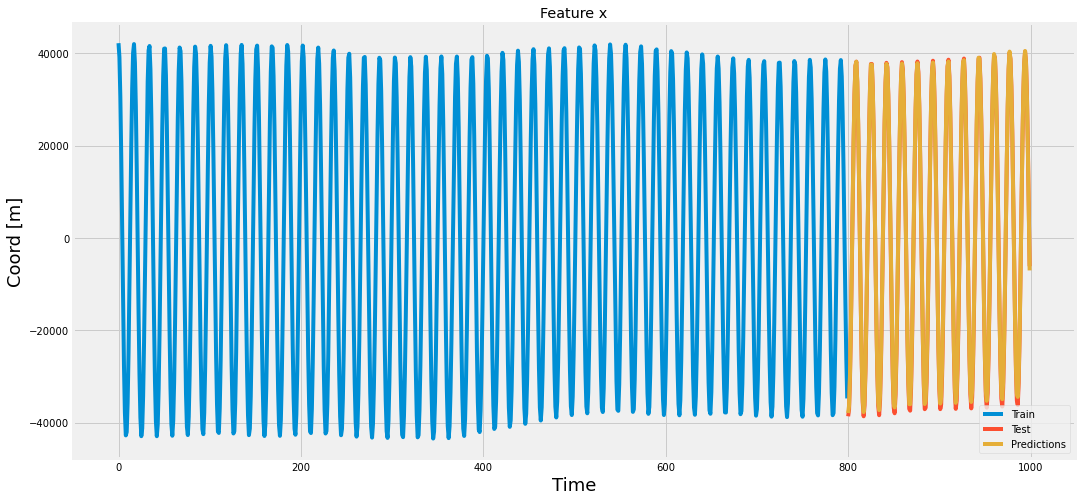

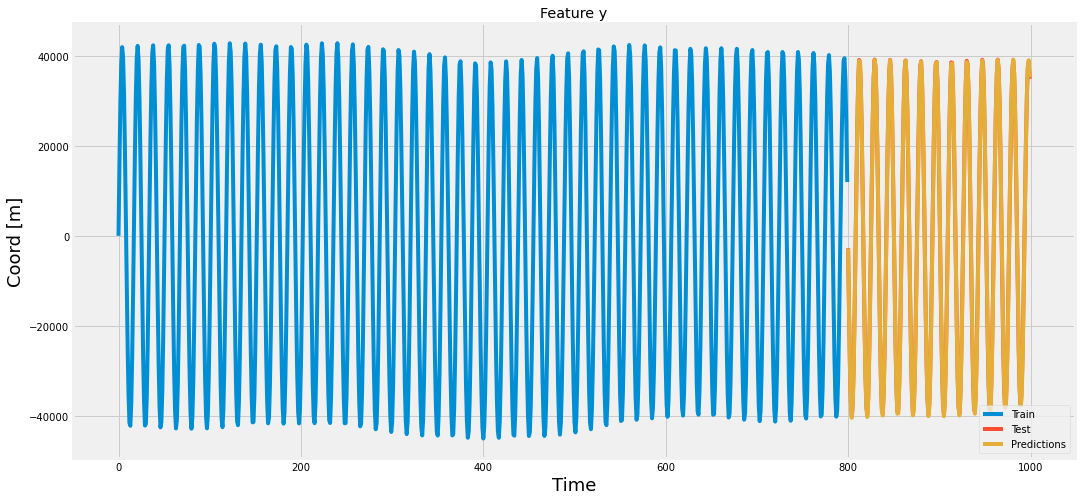

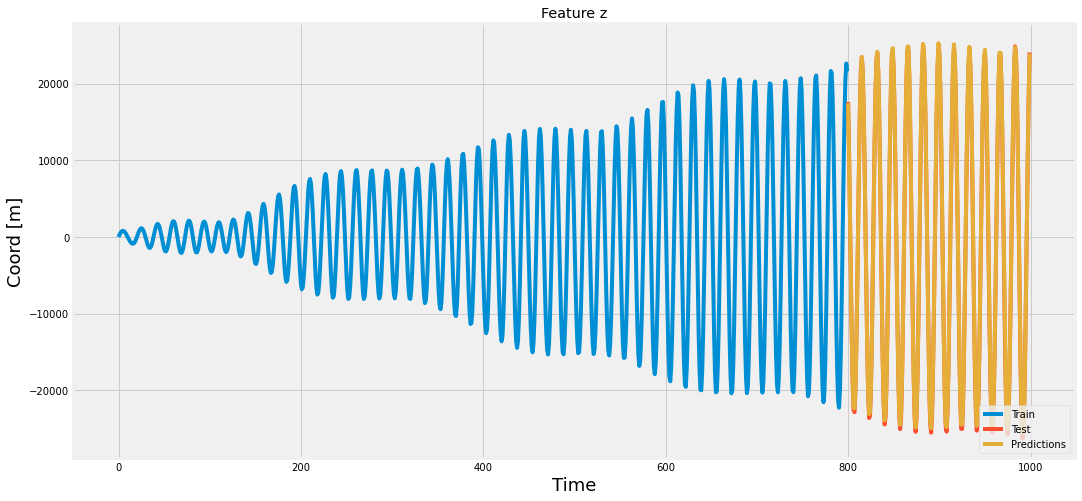

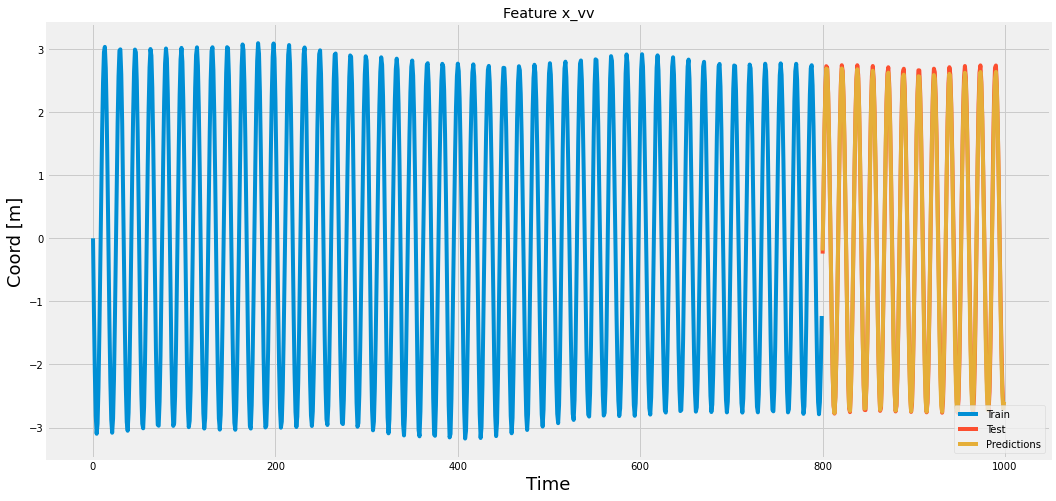

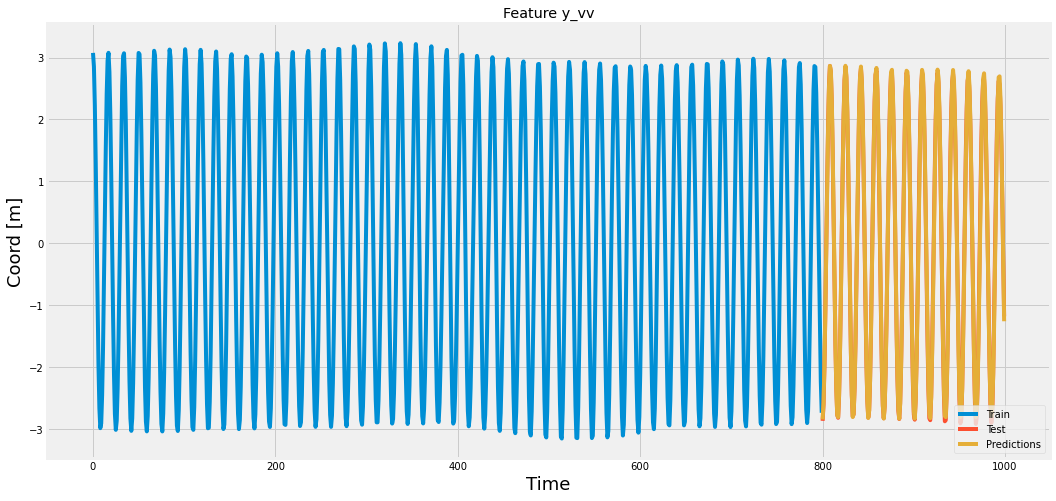

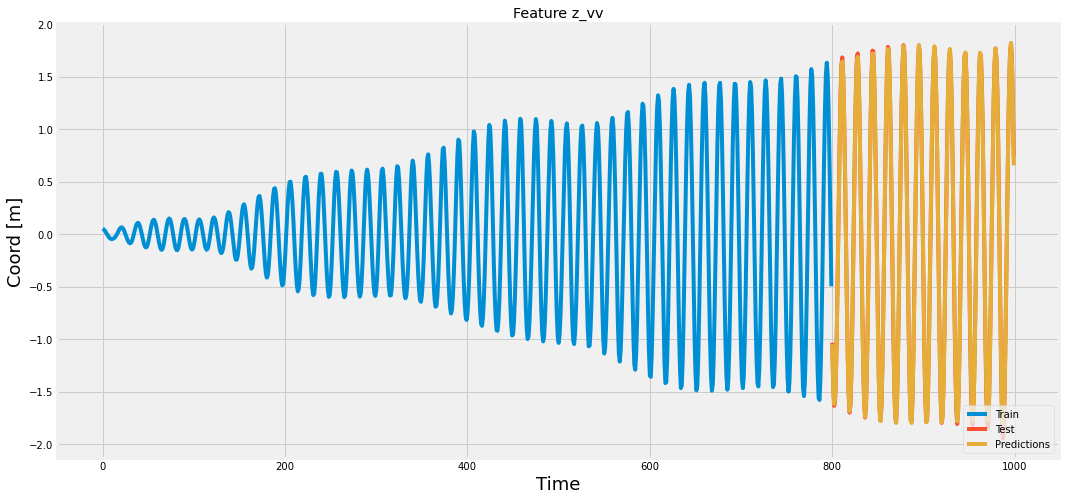

In [9]:
for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(train_df[feature])
    plt.plot(test_df[feature])
    plt.plot(df_pred[feature])

    plt.title(f'Feature {feature}')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Coord [m]', fontsize=18)
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.show()


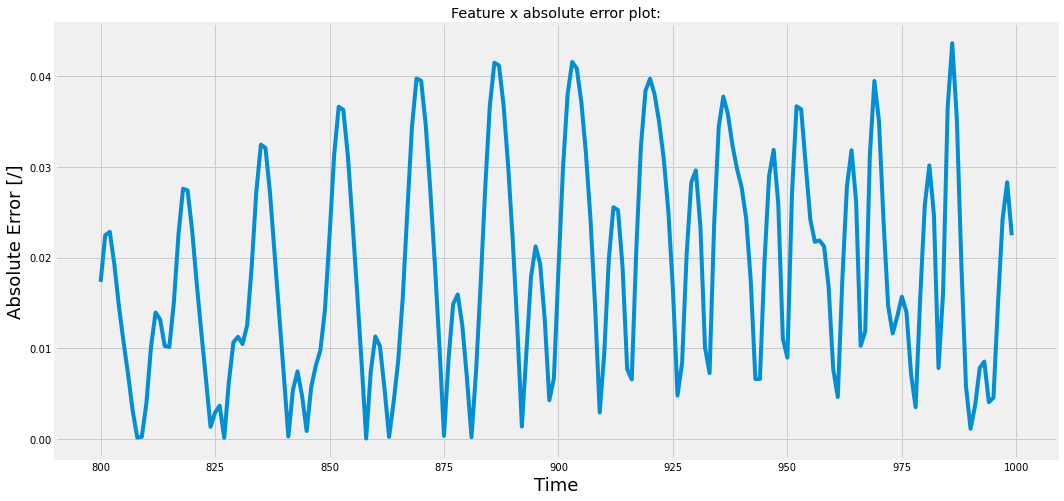

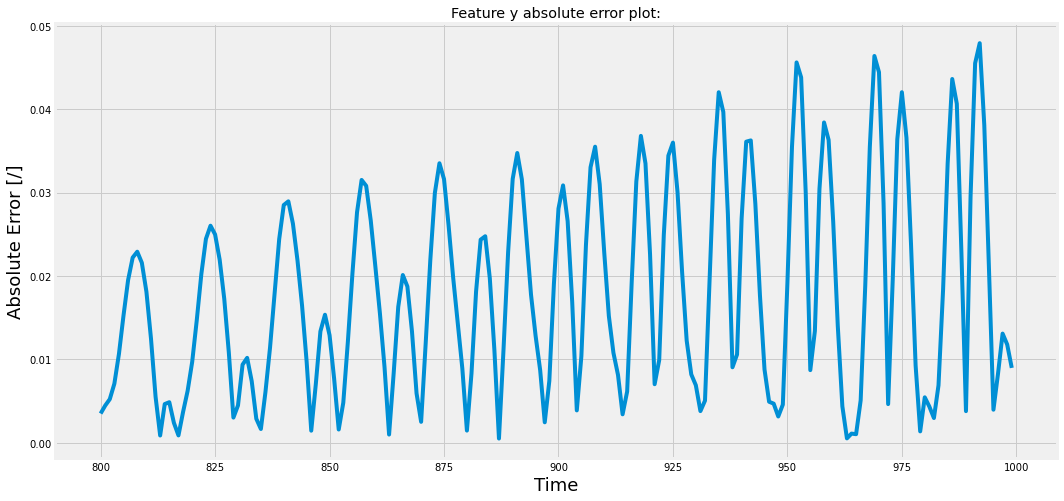

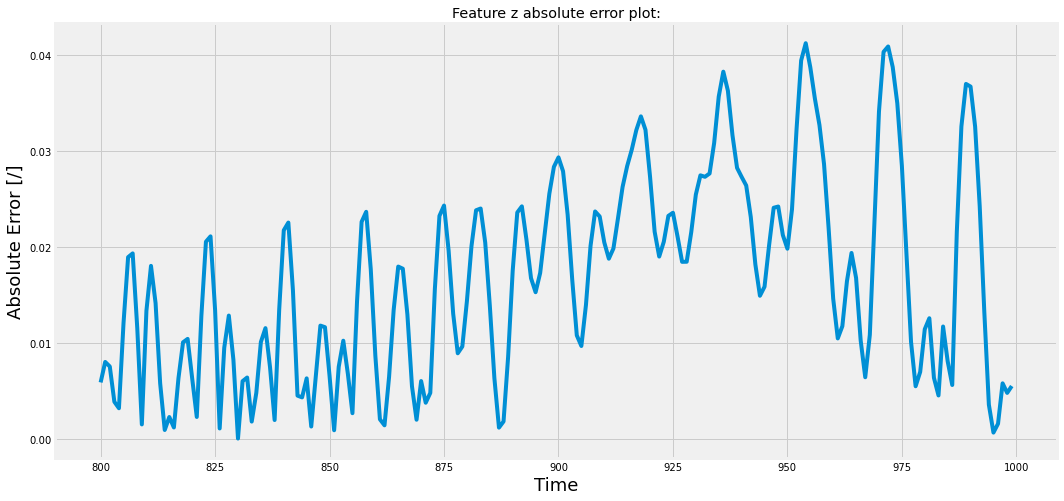

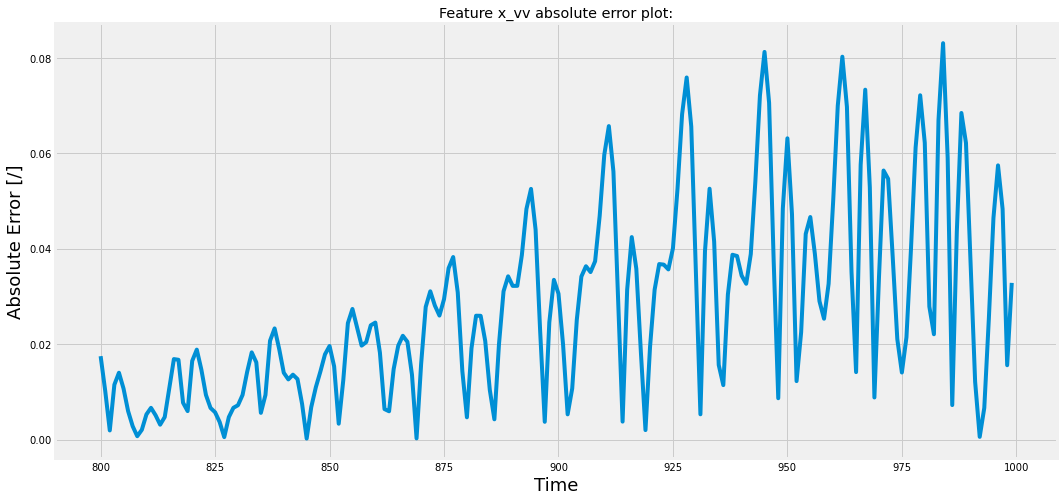

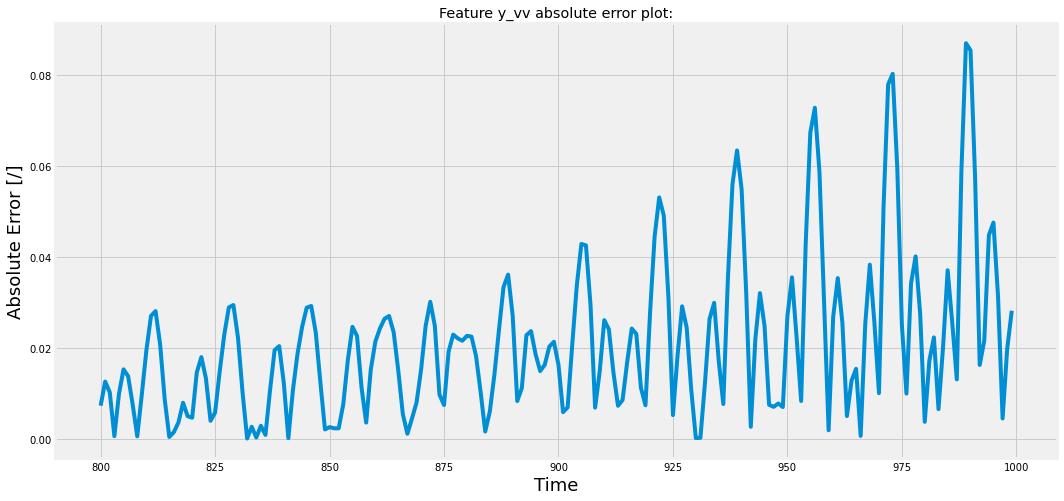

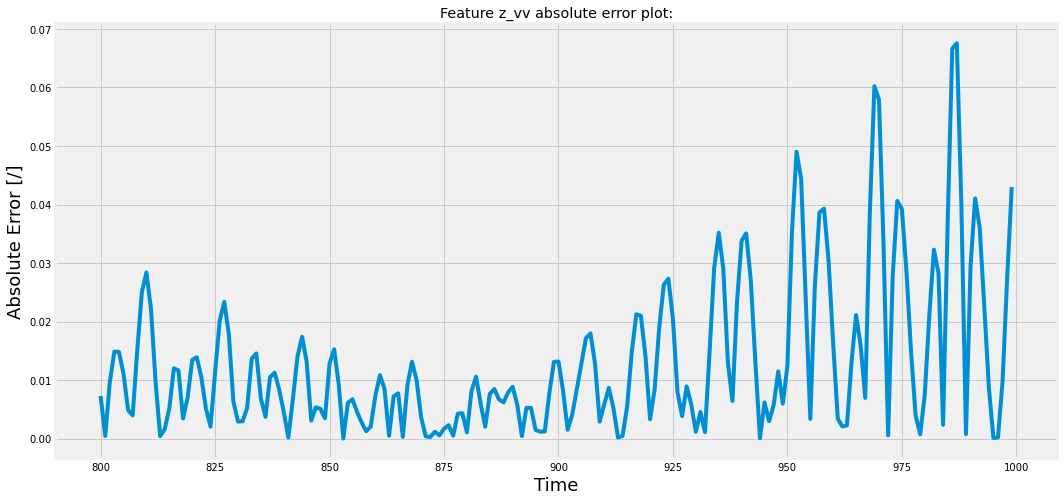

In [10]:
# ABSOLUTE ERRORS:

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/max(test_df[feature]))

    plt.title(f'Feature {feature} absolute error plot:')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Absolute Error [/]', fontsize=18)
    plt.show()

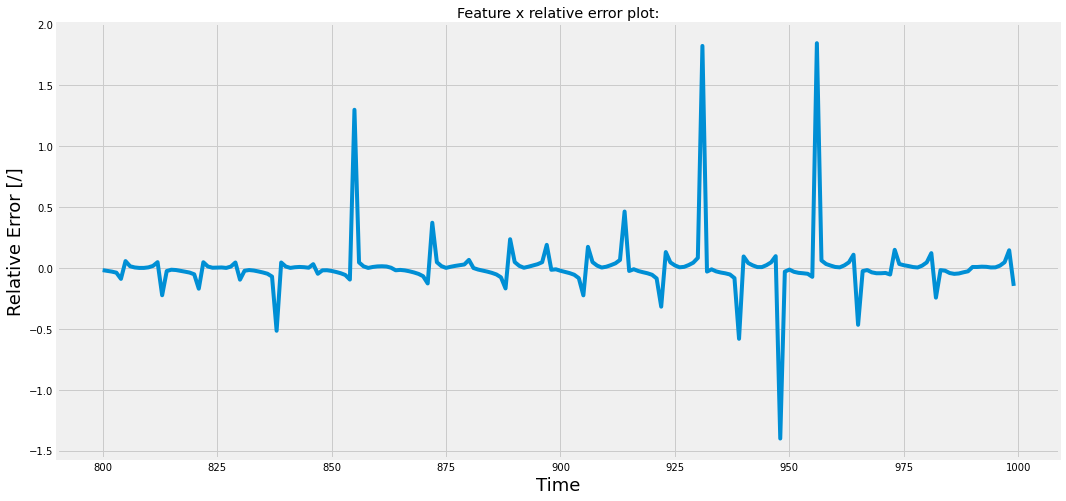

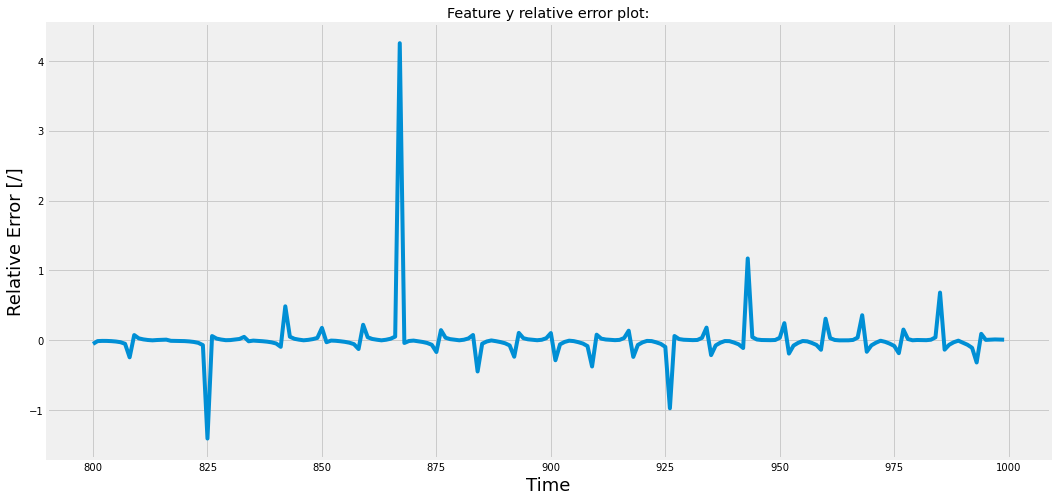

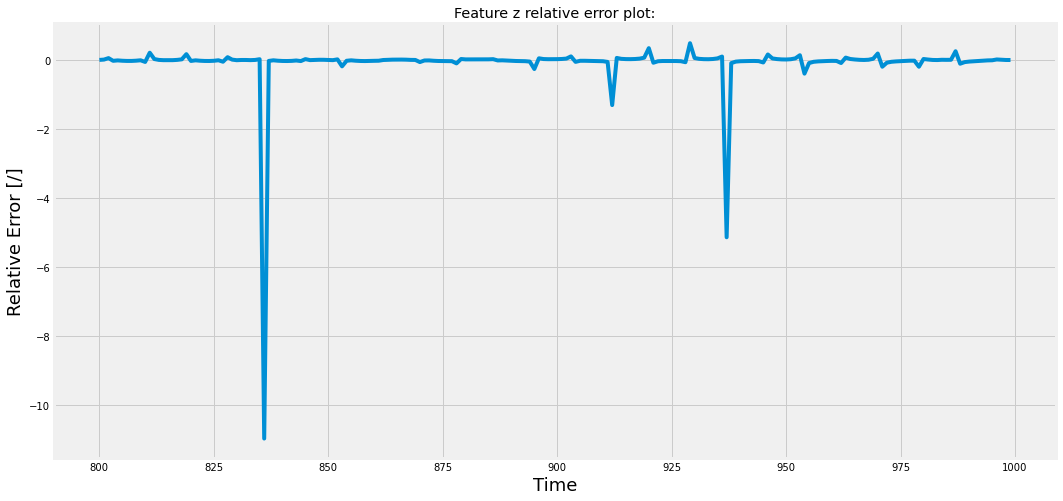

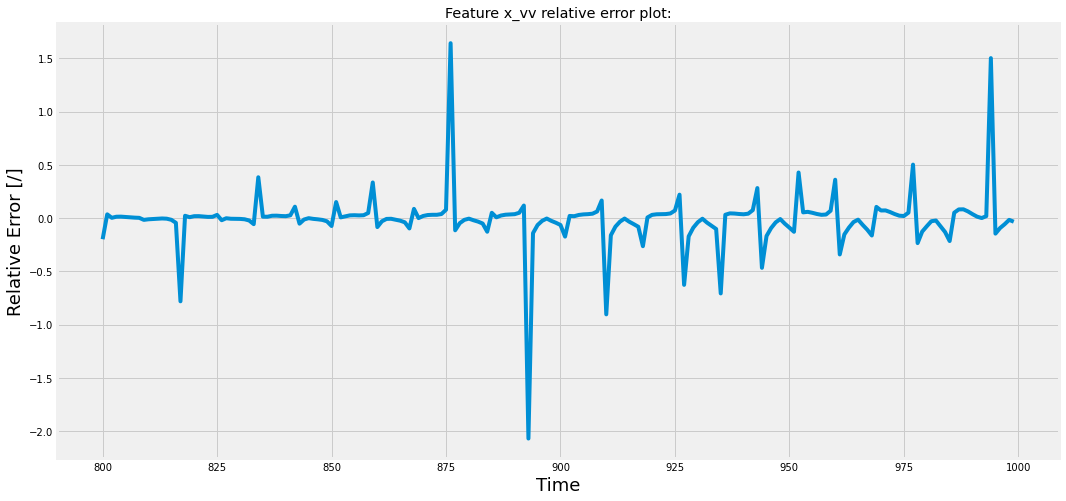

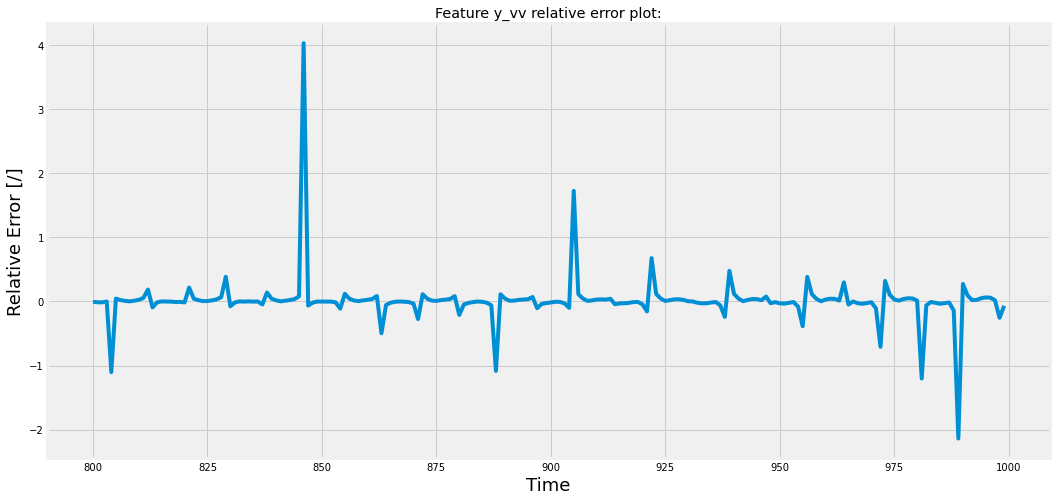

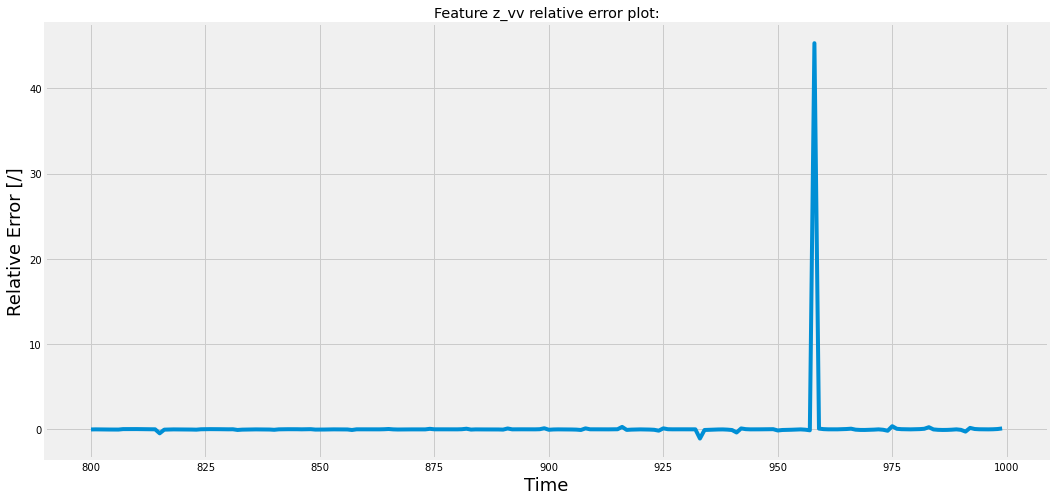

In [11]:
# RELATIVE ERRORS

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/test_df[feature])

    plt.title(f'Feature {feature} relative error plot:')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Relative Error [/]', fontsize=18)
    plt.show()

## Compare and Plot 3D trajectories/errors:

### 1. For 3D Position coordinates

<Figure size 432x288 with 0 Axes>

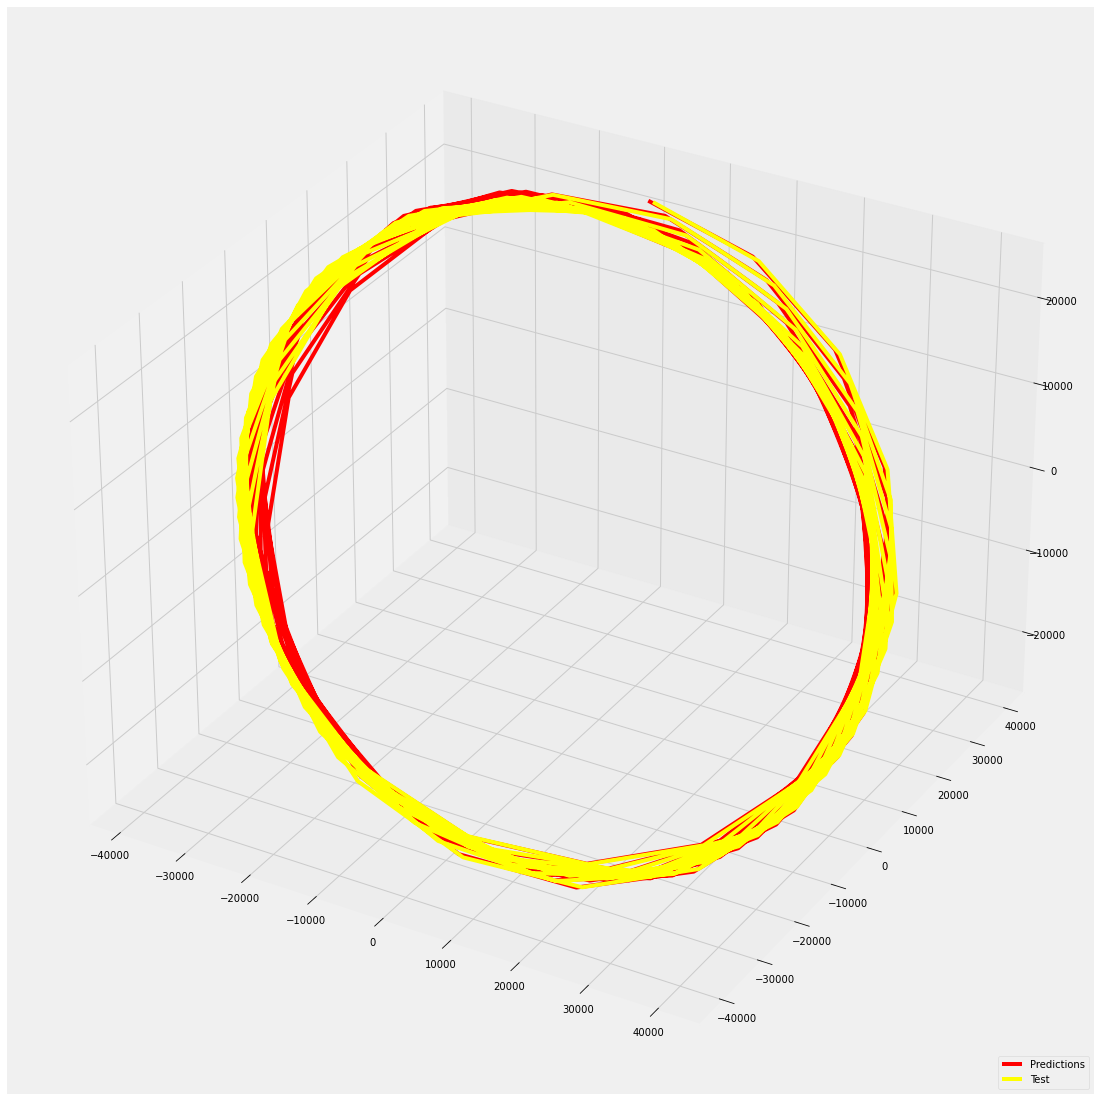

In [49]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x']
y_line = df_pred['y']
z_line = df_pred['z']
plt.plot(x_line, y_line, z_line, 'red')

x_line2 = test_df['x']
y_line2 = test_df['y']
z_line2 = test_df['z']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

plt.legend(['Predictions', 'Test'], loc='lower right')
plt.show()

### 2. For 3D velocity coordinates

<Figure size 432x288 with 0 Axes>

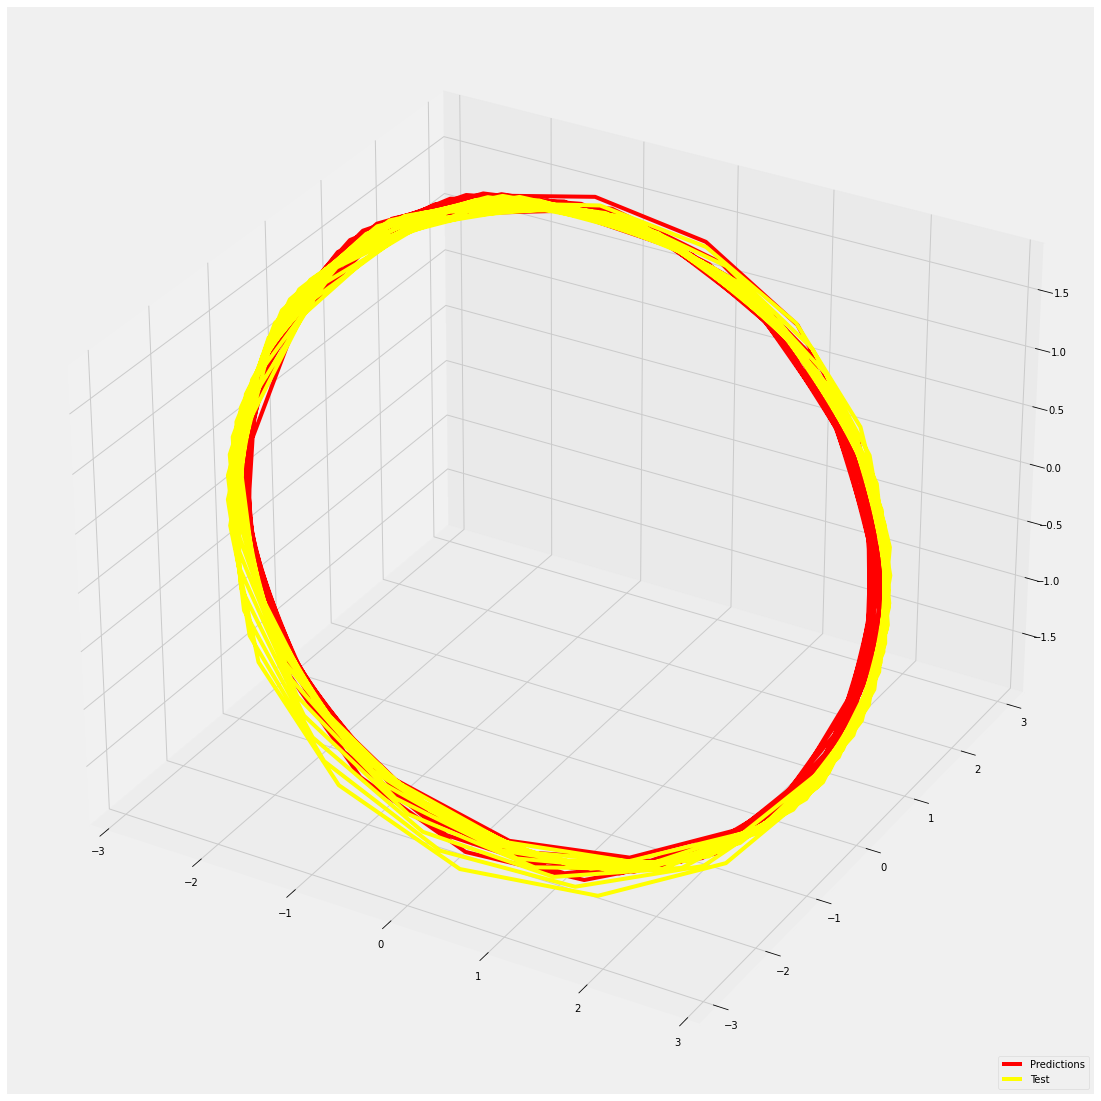

In [62]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x_vv']
y_line = df_pred['y_vv']
z_line = df_pred['z_vv']
plt.plot(x_line, y_line, z_line, 'red')

x_line2 = test_df['x_vv']
y_line2 = test_df['y_vv']
z_line2 = test_df['z_vv']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

plt.legend(['Predictions', 'Test'], loc='lower right')
plt.show()

### Trying to make better/interactive plots :)

In [60]:
from plotly import __version__
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.io as pio

init_notebook_mode(connected=True)
cf.go_offline()

In [61]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x']
y_line = df_pred['y']
z_line = df_pred['z']
plt.iplot(x_line, y_line, z_line, 'red')

x_line2 = test_df['x']
y_line2 = test_df['y']
z_line2 = test_df['z']
plt.iplot(x_line2, y_line2, z_line2, 'yellow')

plt.legend(['Predictions', 'Test'], loc='lower right')
plt.show()

AttributeError: module 'plotly.io' has no attribute 'figure'

In [40]:
import plotly.express as px

fig = px.line_3d(df_pred, x="x", y="y", z="z")
fig = px.line_3d(test_df, x="x", y="y", z="z")
fig.show()

In [36]:
# Init empty predictions DF
df_plot = pd.DataFrame(columns=['x_test', 'y_test', 'z_test', 'x_pred', 'y_pred', 'z_pred'])

df_plot.x_test=test_df.x
df_plot.y_test=test_df.y
df_plot.z_test=test_df.z

df_plot.x_pred=df_pred.x
df_plot.y_pred=df_pred.y
df_plot.z_pred=df_pred.z

df_plot

,x_test,y_test,z_test,x_pred,y_pred,z_pred
800,-38640.279625,-2764.935183,17604.980941,-37941.770471,-2902.683601,17459.093164
801,-37222.004154,-17134.306183,11135.984105,-36316.112147,-17309.400968,10937.045485
802,-30699.416577,-29154.049729,3087.546466,-29778.312304,-29359.311458,2900.330289
803,-19981.800403,-37148.488205,-5420.909441,-19205.347840,-37426.440772,-5516.696596
804,-6568.003292,-40025.406603,-13203.492438,-5978.463570,-40443.193592,-13124.514992
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,37949.565766,21215.179701,-7548.238526
996,31399.515894,31233.289707,1828.575655,30795.454840,31558.660726,1867.509886
997,20906.077447,37238.565267,10967.804062,19927.832386,37751.941360,11111.367272
998,7871.245318,38575.122415,18731.818721,6729.441634,39037.401194,18850.614631
